# Практическое задание №3. Классификация мест залежей нефти и газа

Нефтегазовая отрасль имеет сложную технологическую цепочку, которая начинается с геологической разведки и заканчивается доставкой нефти и газа потребителям. Одной из важных задач является определение места залежей — на суше или в море — на основе различных параметров.

задача: разработать алгоритм машинного обучения, который позволит классифицировать место залежей нефти и газа.

In [1]:
!pip install opendatasets

In [134]:
import opendatasets as od
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [3]:
od.download('https://www.kaggle.com/competitions/classification-of-oil-and-gas-fields')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiays
Your Kaggle Key: ··········
Extracting archive ./classification-of-oil-and-gas-fields/classification-of-oil-and-gas-fields.zip to ./classification-of-oil-and-gas-fields


### Исследование и анализ датасета


In [106]:
train_df = pd.read_csv("./classification-of-oil-and-gas-fields/train_oil.csv")
test_df = pd.read_csv("./classification-of-oil-and-gas-fields/oil_test.csv")
train_df.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [200]:
test_df.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,GAS-CONDENSATE,MATURE PRODUCTION,RIFT,10282,CRETACEOUS,SANDSTONE,745.0,144.0,10.0,8.0
1,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP/TRANSTENSION/SHALE/EVAPORITE/BASEM...,31.4382,31.3616,IEOC,GAS,DECLINING PRODUCTION,WRENCH/DELTA,10499,NEOGENE,SANDSTONE,509.0,410.0,20.0,300.0
2,ALIBEKMOLA,KT I,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,COMPRESSION/EVAPORITE,48.4740,57.6667,KAZAKHOIL AKTOBE,OIL,DEVELOPING,SUB-SALT/FORELAND,6000,CARBONIFEROUS,LIMESTONE,300.0,105.0,10.0,20.0
3,ALWYN NORTH,BRENT (BRENT EAST),UK,EUROPE,NORTH SEA NORTHERN,INVERSION/COMPRESSION/EXTENSION,60.7833,1.7333,TOTAL,OIL,NEARLY DEPLETED,RIFT,9790,JURASSIC,SANDSTONE,886.0,344.0,17.0,500.0
4,ANKLESHWAR,ANKLESHWAR (HAZAD-ARDOL),INDIA,FAR EAST,CAMBAY,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,21.6000,72.9167,ONGC,OIL,MATURE PRODUCTION,WRENCH/RIFT,2950,PALEOGENE,SANDSTONE,670.0,0.0,21.0,250.0


In [201]:
# Посмотрим количество строк и столбцов
print(f"Размеры тренировочного датасета: {train_df.shape}")
print(f"Размеры тестового датасета: {test_df.shape}")

Размеры тренировочного датасета: (268, 27)
Размеры тестового датасета: (133, 19)


Изучим тренировочный набор данных

In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [50]:
train_df.describe(include='all')

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
count,309,309,282,271,271,309,282.00000,279.000000,309,309,309,309,309,309.000000,309,309,309.000000,309.000000,309.000000,309.000000
unique,285,258,42,7,93,55,NaN,NaN,138,3,4,13,43,NaN,22,13,NaN,NaN,NaN,NaN
top,ERSKINE,BRENT,USA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,NaN,NaN,NUMEROUS,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,NaN,CRETACEOUS,SANDSTONE,NaN,NaN,NaN,NaN
freq,3,8,80,110,24,72,NaN,NaN,28,218,231,88,78,NaN,78,184,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,35.62426,-12.508435,NaN,NaN,NaN,NaN,NaN,6755.669903,NaN,NaN,760.087379,183.683236,17.825178,476.994757
std,NaN,NaN,NaN,NaN,NaN,NaN,22.19116,86.387220,NaN,NaN,NaN,NaN,NaN,3628.094135,NaN,NaN,1353.934404,282.252489,7.171048,1000.140605
min,NaN,NaN,NaN,NaN,NaN,NaN,-38.39890,-151.615300,NaN,NaN,NaN,NaN,NaN,220.000000,NaN,NaN,11.000000,2.120000,1.100000,0.010000
25%,NaN,NaN,NaN,NaN,NaN,NaN,28.24915,-102.336500,NaN,NaN,NaN,NaN,NaN,4059.000000,NaN,NaN,128.000000,45.000000,12.000000,10.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,38.13500,1.810000,NaN,NaN,NaN,NaN,NaN,6500.000000,NaN,NaN,312.000000,110.000000,17.000000,68.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,52.13360,56.179900,NaN,NaN,NaN,NaN,NaN,9186.000000,NaN,NaN,715.000000,205.000000,23.600000,390.000000


20 переменных: 13 категориальных (одна из них целевая), 7 численных.


Посмотрим сколько пропусков в данных

In [51]:
train_df.isna().sum()

,0
Field name,0
Reservoir unit,0
Country,27
Region,38
Basin name,38
Tectonic regime,0
Latitude,27
Longitude,30
Operator company,0
Onshore/Offshore,0


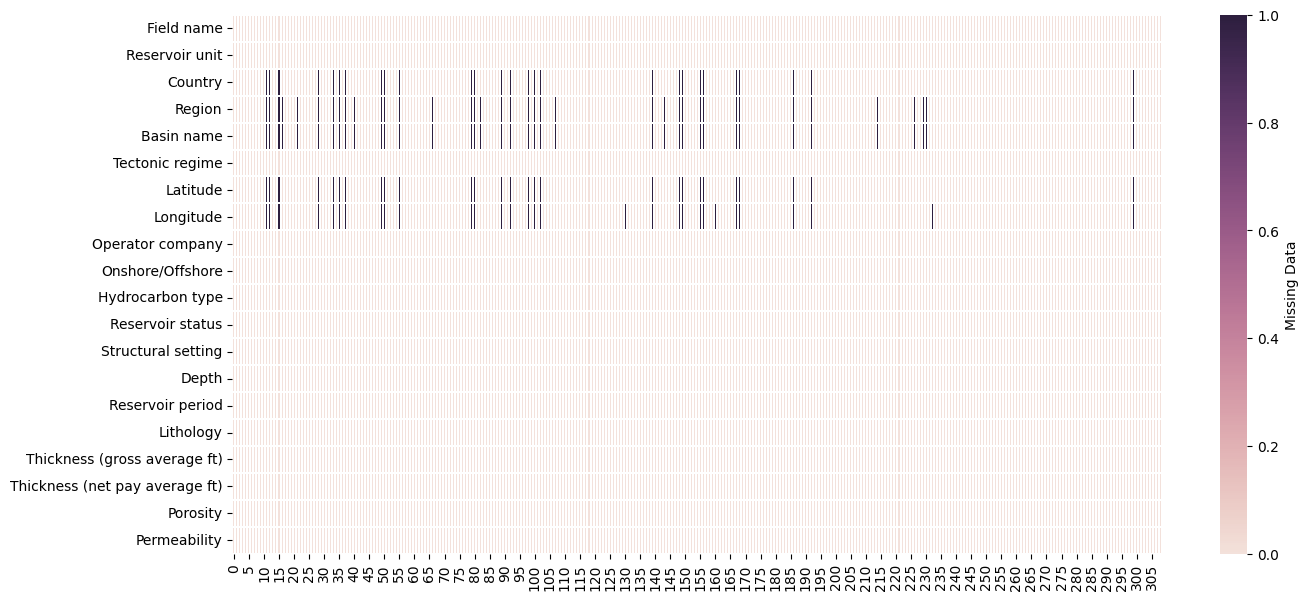

In [52]:
# Визуализируем пропуски в данных с помощью тепловой карты

plt.figure(figsize=(15,7))

cmap = sns.cubehelix_palette(as_cmap=True, light=.9)

sns.heatmap(train_df.isna().transpose(), cmap=cmap,
            cbar_kws={'label': 'Missing Data'}, linewidths=0.05)

plt.savefig("visualizing_missing_data_in_train_with_heatmap_Seaborn_Python.png", dpi=100)

In [53]:
# процент пропущенных значений
df_nan = train_df.loc[:, train_df.isnull().any()]
df_nan.isnull().sum() / len(df_nan) * 100

,0
Country,8.737864
Region,12.297735
Basin name,12.297735
Latitude,8.737864
Longitude,9.708738


Есть несколько колонок с пропущенными данными - это Country, Region, Basin name, Latitude, Longitude. На тепловых картах видно, что пропусков немного (в районе 10 процентов от набора данных). Удалим эти строки с пропусками.

In [107]:
train_df = train_df.dropna()

In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      268 non-null    object 
 1   Reservoir unit                  268 non-null    object 
 2   Country                         268 non-null    object 
 3   Region                          268 non-null    object 
 4   Basin name                      268 non-null    object 
 5   Tectonic regime                 268 non-null    object 
 6   Latitude                        268 non-null    float64
 7   Longitude                       268 non-null    float64
 8   Operator company                268 non-null    object 
 9   Onshore/Offshore                268 non-null    object 
 10  Hydrocarbon type                268 non-null    object 
 11  Reservoir status                268 non-null    object 
 12  Structural setting              268 non-n

Пропуски удалили, в тренировочной выборке осталось 268 строчек

Посмотрим на распределение целевой переменной

In [68]:
train_df['Onshore/Offshore'].value_counts()

,count
Onshore/Offshore,
ONSHORE,187
OFFSHORE,77
ONSHORE-OFFSHORE,4


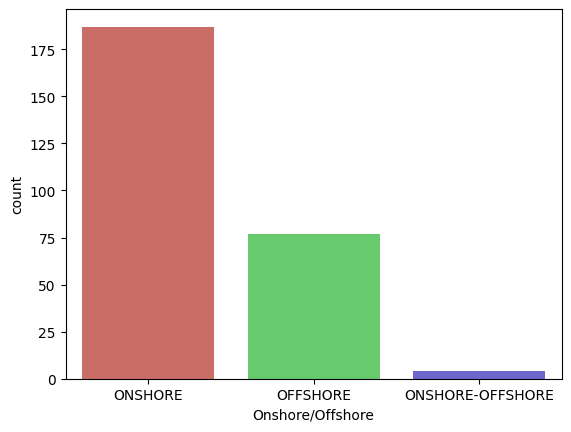

In [18]:
sns.countplot(x ='Onshore/Offshore', data = train_df, palette='hls', hue='Onshore/Offshore')
plt.show()

Видим значительный дисбаланс классов.

Посмотрим распределения числовых и категориальных признаков

In [20]:
numeric_features = ['Latitude', 'Longitude', 'Depth', 'Thickness (gross average ft)',
                   'Thickness (net pay average ft)', 'Porosity', 'Permeability']

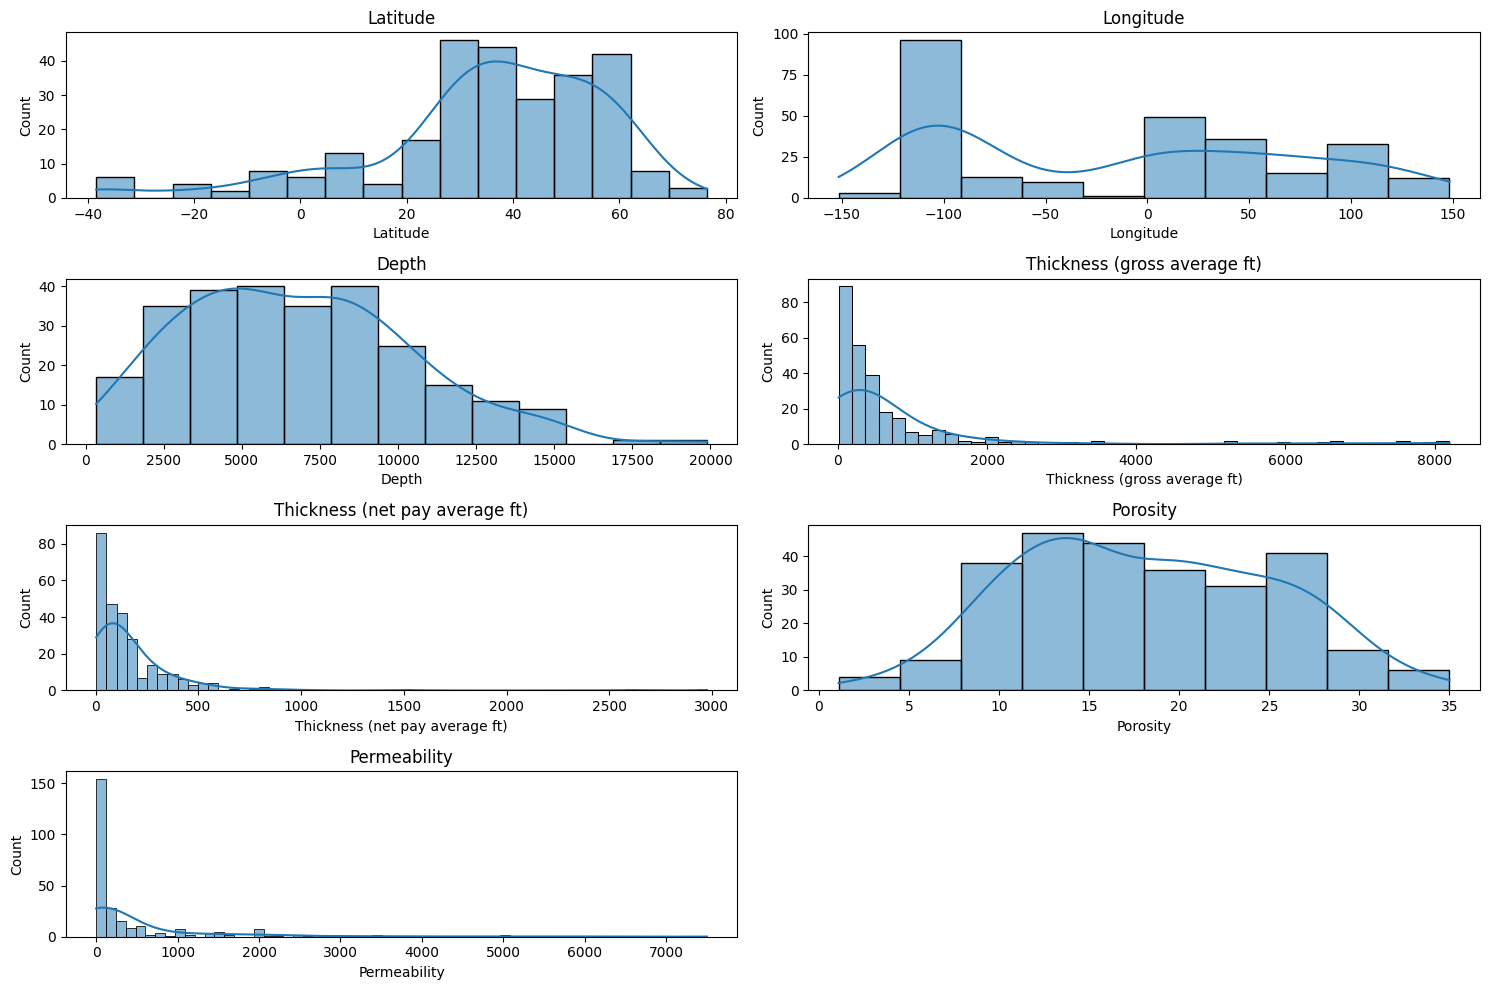

In [22]:
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_features):
    plt.subplot(4, 2, i+1)
    sns.histplot(train_df[col], kde=True)
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

Для категориальных признаков посмотрим количество категорий

In [35]:
categorical_features = ['Field name', 'Reservoir unit', 'Country', 'Region', 'Basin name',
                        'Tectonic regime', 'Operator company', 'Hydrocarbon type',
                        'Reservoir status', 'Structural setting', 'Reservoir period',
                        'Lithology']

In [36]:
for col in categorical_features:
    print(f'{col} - {len(train_df[col].unique())} уникальных значений')

Field name - 251 уникальных значений
Reservoir unit - 225 уникальных значений
Country - 41 уникальных значений
Region - 7 уникальных значений
Basin name - 92 уникальных значений
Tectonic regime - 54 уникальных значений
Operator company - 123 уникальных значений
Hydrocarbon type - 4 уникальных значений
Reservoir status - 13 уникальных значений
Structural setting - 41 уникальных значений
Reservoir period - 21 уникальных значений
Lithology - 13 уникальных значений


In [42]:
for col in categorical_features:
    display(train_df[col].value_counts().head(10))
    print()

,count
Field name,
ERSKINE,3
LAOJUNMIAO,3
LLOYDMINSTER AREA,2
BRAGE,2
ELK BASIN,2
POKACHEV,2
HIBERNIA,2
SAIH RAWL,2
KHAFJI,2


,count
Reservoir unit,
BRENT,8
SAN ANDRES,6
SHUAIBA,5
TOR-EKOFISK,4
KALOL,3
RED SERIES,3
HUECO,2
CHARLES,2
ARAB D,2


,count
Country,
USA,77
CANADA,33
UK,19
CHINA,19
RUSSIA,16
NORWAY,11
INDONESIA,9
AUSTRALIA,7
OMAN,6


,count
Region,
NORTH AMERICA,110
FAR EAST,46
EUROPE,38
FORMER SOVIET UNION,25
MIDDLE EAST,20
AFRICA,17
LATIN AMERICA,12


,count
Basin name,
WESTERN CANADA,24
GULF OF MEXICO NORTHERN ONSHORE,19
NORTH SEA CENTRAL,14
NORTH SEA NORTHERN,12
WILLISTON,10
PERMIAN,10
BOHAI,8
ANADARKO,7
SIBERIAN WESTERN,7


,count
Tectonic regime,
COMPRESSION,57
EXTENSION,26
COMPRESSION/EROSION,25
COMPRESSION/EVAPORITE,18
INVERSION/COMPRESSION/EXTENSION,17
EXTENSION/EROSION,12
GRAVITY/EXTENSION/EVAPORITE,10
INVERSION/COMPRESSION/EXTENSION/EROSION,7
GRAVITY/EXTENSION/EVAPORITE/SYNSEDIMENTATION,7


,count
Operator company,
NUMEROUS,26
CHEVRON,15
PETROCHINA,14
BP,9
SHELL,9
EXXONMOBIL,8
STATOILHYDRO,8
CONOCOPHILLIPS,8
PDO,6


,count
Hydrocarbon type,
OIL,200
GAS,40
GAS-CONDENSATE,26
CARBON DIOXIDE,2


,count
Reservoir status,
DECLINING PRODUCTION,75
MATURE PRODUCTION,55
NEARLY DEPLETED,49
PLATEAU PRODUCTION,25
DEVELOPING,20
REJUVENATING,15
UNKNOWN,7
UNDEVELOPED,6
ABANDONED,6


,count
Structural setting,
FORELAND,67
RIFT,43
INTRACRATONIC,27
THRUST,14
PASSIVE MARGIN,12
SALT/FORELAND,11
SALT/PASSIVE MARGIN,9
DELTA/PASSIVE MARGIN,7
INVERSION/RIFT,7


,count
Reservoir period,
CRETACEOUS,70
JURASSIC,35
NEOGENE,34
PALEOGENE,34
CARBONIFEROUS,25
PERMIAN,19
DEVONIAN,13
TRIASSIC,8
CRETACEOUS-PALEOGENE,7


,count
Lithology,
SANDSTONE,160
DOLOMITE,37
LIMESTONE,32
CONGLOMERATE,6
THINLY-BEDDED SANDSTONE,6
CHALK,6
SHALY SANDSTONE,5
LOW-RESISTIVITY SANDSTONE,5
CHALKY LIMESTONE,5


Заметим, что колонка 'Tectonic regime' имеет множественные категории

In [43]:
train_df['Tectonic regime'].value_counts()

,count
Tectonic regime,
COMPRESSION,57
EXTENSION,26
COMPRESSION/EROSION,25
COMPRESSION/EVAPORITE,18
INVERSION/COMPRESSION/EXTENSION,17
EXTENSION/EROSION,12
GRAVITY/EXTENSION/EVAPORITE,10
INVERSION/COMPRESSION/EXTENSION/EROSION,7
GRAVITY/EXTENSION/EVAPORITE/SYNSEDIMENTATION,7


По результатам первичного анализа мы удалили пропущенные значения в датасете, выявили дисбаланс классов и одну категориальную переменную с множественными категориями, которые необходимо обработать. Перейдем к предобработке данных

### Предобработка данных

In [111]:
# Закодируем целевую переменную так как указано в задании (ONSHORE - 1, OFFSHORE - 0, ONSHORE-OFFSHORE - 2)
train_df['Onshore/Offshore'] = train_df['Onshore/Offshore'].map({'ONSHORE': 1, 'OFFSHORE': 0, 'ONSHORE-OFFSHORE': 2})

In [112]:
# Обработаем переменную Tectonic regime (тектонический режим)

# Преобразование строки с категориями в список (list) из категорий
train_df['Tectonic regime'] = train_df['Tectonic regime'].str.split('/')

# Инициализация MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Применение MultiLabelBinarizer к колонке 'genres'
tectonic_regimes_encoded = mlb.fit_transform(train_df['Tectonic regime'])

# Создание нового DataFrame с закодированными жанрами
tectonic_regimes_df = pd.DataFrame(tectonic_regimes_encoded, columns=mlb.classes_)
tectonic_regimes_df

,BASEMENT-I,COMPRESSION,DIAPIR,EROSION,EVAPORITE,EXTENSION,GRAVITY,INVERSION,LINKED,REACTIVATION,SHALE,STRIKE-SLIP,SYNSEDIMENTATION,TRANSPRESSION,TRANSTENSION,UPLIFT
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
264,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0
265,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
266,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [113]:
# Соединение с исходным DataFrame

# Сохраняем исходные индексы
tectonic_regimes_df.index = train_df.index
train_df = pd.concat([train_df, tectonic_regimes_df], axis=1)

train_df

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,...,GRAVITY,INVERSION,LINKED,REACTIVATION,SHALE,STRIKE-SLIP,SYNSEDIMENTATION,TRANSPRESSION,TRANSTENSION,UPLIFT
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,"[COMPRESSION, EVAPORITE]",51.0000,44.8042,NIZHNEVOLZHSKNET,1,...,0,0,0,0,0,0,0,0,0,0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,[EXTENSION],-19.6017,-39.8332,PETROBRAS,1,...,0,0,0,0,0,0,0,0,0,0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,"[COMPRESSION, EVAPORITE]",26.0800,49.8100,SAUDI ARAMCO,1,...,0,0,0,0,0,0,0,0,0,0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,[EXTENSION],61.3833,1.7500,CNR,0,...,0,0,0,0,0,0,0,0,0,0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,[COMPRESSION],53.2287,-115.8008,NUMEROUS,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,HIDES,IMBURU-TORO,PAPUA NEW GUINEA,FAR EAST,PAPUAN FTB,[COMPRESSION],-6.0136,142.8409,OIL SEARCH LTD,1,...,0,0,0,0,0,0,0,0,0,0
305,DRAKE POINT,DRAKE POINT-INTREPID INLET,CANADA,NORTH AMERICA,SVERDRUP,"[COMPRESSION, EVAPORITE, EXTENSION, LINKED]",76.4462,-108.9172,PANARCTIC OILS,1,...,0,0,1,0,0,0,0,0,0,0
306,ALTAMONT-BLUEBELL,GREEN RIVER AND COLTON/WASATCH,USA,NORTH AMERICA,UINTA,[COMPRESSION],40.3000,-110.2100,NUMEROUS,1,...,0,0,0,0,0,0,0,0,0,0
307,BELL CREEK,MUDDY,USA,NORTH AMERICA,POWDER RIVER,[COMPRESSION],45.1039,-105.0967,SAMUEL GARY,1,...,0,0,0,0,0,0,0,0,0,0


In [203]:
# Аналогично обработаем тестовую выборку

test_df['Tectonic regime'] = test_df['Tectonic regime'].str.split('/')
test_tectonic_regimes_encoded = mlb.fit_transform(test_df['Tectonic regime'])
test_tectonic_regimes_df = pd.DataFrame(test_tectonic_regimes_encoded, columns=mlb.classes_)
# Сохраняем исходные индексы
test_tectonic_regimes_df.index = test_df.index
test_df = pd.concat([test_df, test_tectonic_regimes_df], axis=1)

test_df.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Hydrocarbon type,...,EXTENSION,GRAVITY,INVERSION,LINKED,SHALE,STRIKE-SLIP,SYNSEDIMENTATION,TRANSPRESSION,TRANSTENSION,UPLIFT
0,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,[EXTENSION],29.7422,28.4925,GUPCO,GAS-CONDENSATE,...,1,0,0,0,0,0,0,0,0,0
1,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,"[STRIKE-SLIP, TRANSTENSION, SHALE, EVAPORITE, ...",31.4382,31.3616,IEOC,GAS,...,0,0,0,0,1,1,0,0,1,0
2,ALIBEKMOLA,KT I,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,"[COMPRESSION, EVAPORITE]",48.4740,57.6667,KAZAKHOIL AKTOBE,OIL,...,0,0,0,0,0,0,0,0,0,0
3,ALWYN NORTH,BRENT (BRENT EAST),UK,EUROPE,NORTH SEA NORTHERN,"[INVERSION, COMPRESSION, EXTENSION]",60.7833,1.7333,TOTAL,OIL,...,1,0,1,0,0,0,0,0,0,0
4,ANKLESHWAR,ANKLESHWAR (HAZAD-ARDOL),INDIA,FAR EAST,CAMBAY,"[STRIKE-SLIP, TRANSPRESSION, BASEMENT-I]",21.6000,72.9167,ONGC,OIL,...,0,0,0,0,0,1,0,1,0,0


In [115]:
# Закодируем другие категориальыне переменные
categ_features = ['Field name', 'Reservoir unit', 'Country', 'Region',
                  'Basin name', 'Operator company', 'Hydrocarbon type',
                  'Reservoir status', 'Structural setting', 'Reservoir period',
                  'Lithology']

# Создаем OrdinalEncoder, который заменит категории числами
# Если в тестовой выборке появятся неизвестные категории, они будут заменены на -1
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Обучаем encoder на тренировочных данных и сразу трансформируем train_df и test_df
train_encoded = encoder.fit_transform(train_df[categ_features])
test_encoded = encoder.transform(test_df[categ_features])

# Заменяем старые категориальные столбцы новыми закодированными
train_df[categ_features] = train_encoded
test_df[categ_features] = test_encoded

### Подбор признаков, их анализ и оценка важности

In [116]:
tectonic_regimes_df.columns

Index(['BASEMENT-I', 'COMPRESSION', 'DIAPIR', 'EROSION', 'EVAPORITE',
       'EXTENSION', 'GRAVITY', 'INVERSION', 'LINKED', 'REACTIVATION', 'SHALE',
       'STRIKE-SLIP', 'SYNSEDIMENTATION', 'TRANSPRESSION', 'TRANSTENSION',
       'UPLIFT'],
      dtype='object')

In [117]:
df = train_df.drop(columns=tectonic_regimes_df.columns)
df

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,250.0,119.0,26.0,3.0,85.0,"[COMPRESSION, EVAPORITE]",51.0000,44.8042,68.0,1,3.0,2.0,5.0,1870,1.0,7.0,262.0,33.0,24.0,30.0
1,121.0,96.0,3.0,4.0,20.0,[EXTENSION],-19.6017,-39.8332,80.0,1,3.0,6.0,15.0,4843,13.0,7.0,2133.0,72.0,23.0,350.0
2,0.0,14.0,27.0,5.0,80.0,"[COMPRESSION, EVAPORITE]",26.0800,49.8100,93.0,1,3.0,8.0,5.0,6050,8.0,5.0,250.0,184.0,21.0,410.0
3,150.0,34.0,37.0,1.0,50.0,[EXTENSION],61.3833,1.7500,30.0,0,3.0,6.0,16.0,8988,8.0,7.0,425.0,300.0,22.0,750.0
4,233.0,132.0,4.0,6.0,87.0,[COMPRESSION],53.2287,-115.8008,70.0,1,3.0,12.0,5.0,9306,5.0,3.0,233.0,167.0,11.8,1407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,94.0,80.0,24.0,2.0,55.0,[COMPRESSION],-6.0136,142.8409,72.0,1,2.0,1.0,32.0,9905,9.0,7.0,490.0,240.0,10.0,100.0
305,58.0,59.0,4.0,6.0,77.0,"[COMPRESSION, EVAPORITE, EXTENSION, LINKED]",76.4462,-108.9172,75.0,1,1.0,11.0,5.0,3390,8.0,7.0,100.0,71.0,20.0,566.0
306,5.0,68.0,38.0,6.0,83.0,[COMPRESSION],40.3000,-110.2100,70.0,1,3.0,5.0,5.0,15250,13.0,7.0,8000.0,575.0,5.0,0.1
307,23.0,128.0,38.0,6.0,61.0,[COMPRESSION],45.1039,-105.0967,92.0,1,3.0,6.0,5.0,4300,3.0,7.0,45.0,23.0,28.5,2250.0


<Axes: >

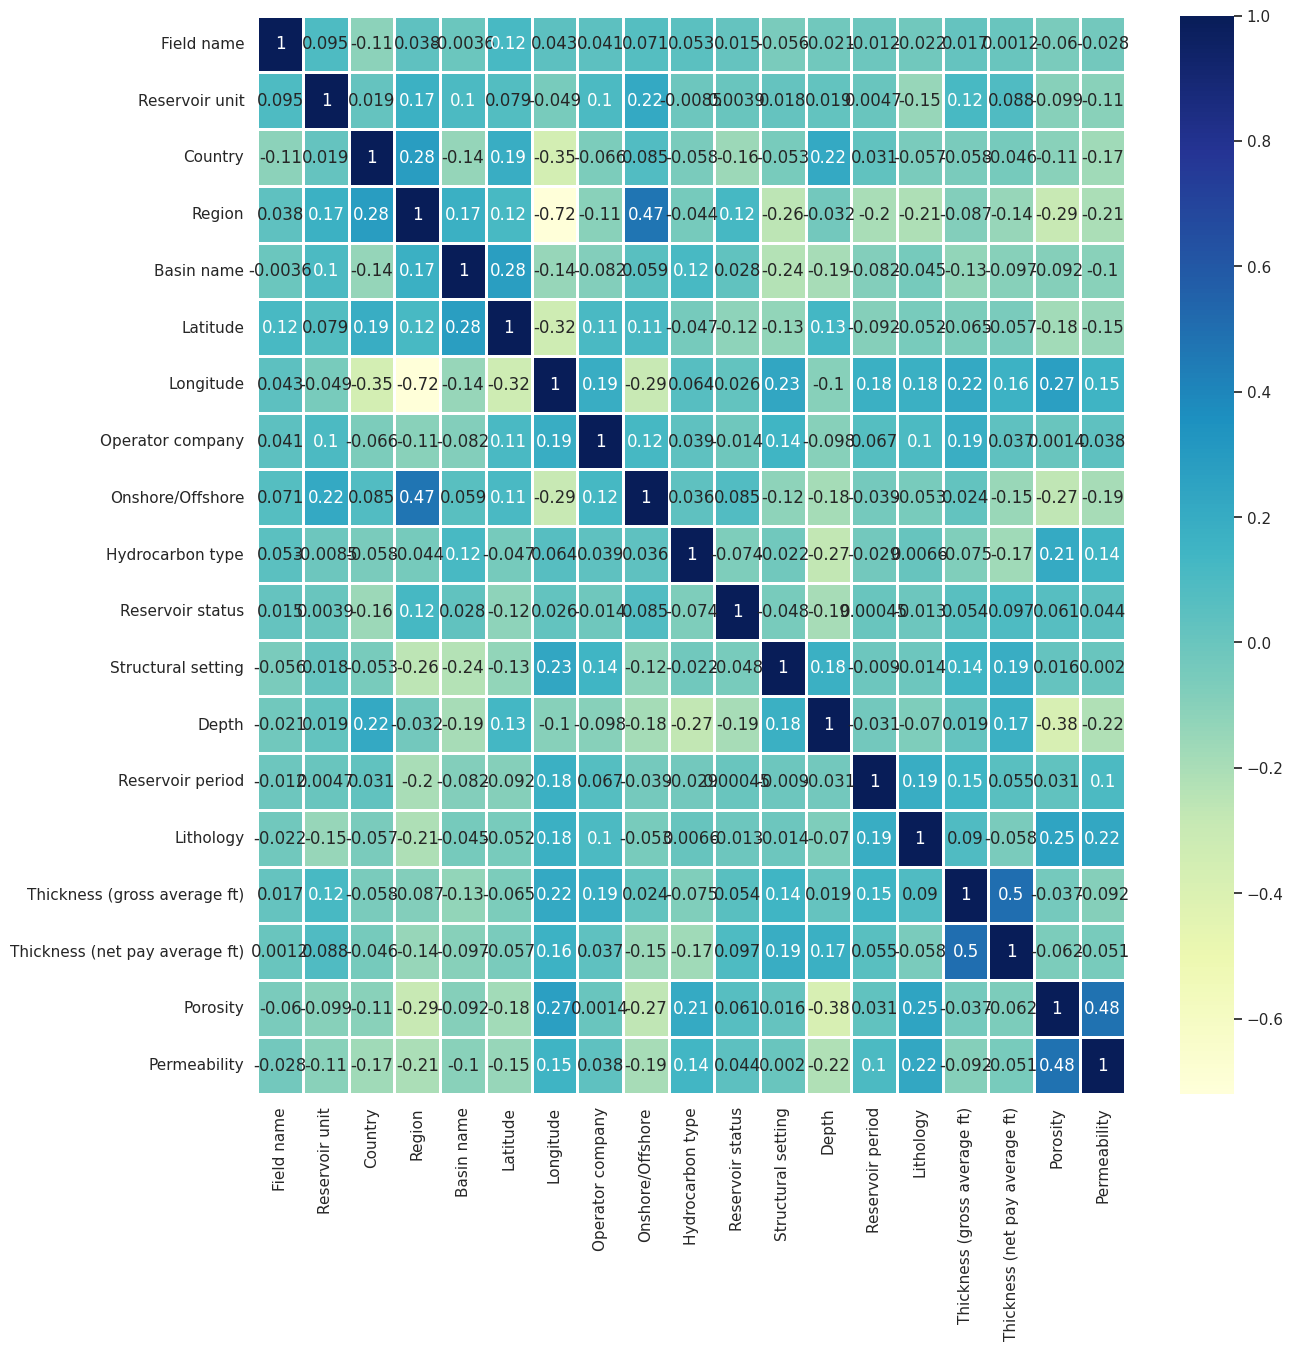

In [118]:
# Теперь построим матрицу корреляций
sns.set(rc = {'figure.figsize':(14, 14)})

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu", linecolor='white', linewidths=1)

Наибольшая корреляция целевой переменной с признаком Region. С остальными корреляция слабее.

In [119]:
# Удалим столбцы, где корреляция с целевой переменной совсем маленькая (менее 0.1 по модулю)
# А также удалим исходный столбец Tectonic regime, т.к. мы добавили закодирвоанные One-hot-encoding столбцы для тектонических режимов
train_df = train_df.drop(columns=['Field name', 'Country', 'Basin name', 'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)','Tectonic regime'], axis=1)
test_df = test_df.drop(columns=['Field name', 'Country', 'Basin name', 'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)','Tectonic regime'], axis=1)

In [120]:
train_df.columns

Index(['Reservoir unit', 'Region', 'Latitude', 'Longitude', 'Operator company',
       'Onshore/Offshore', 'Structural setting', 'Depth',
       'Thickness (net pay average ft)', 'Porosity', 'Permeability',
       'BASEMENT-I', 'COMPRESSION', 'DIAPIR', 'EROSION', 'EVAPORITE',
       'EXTENSION', 'GRAVITY', 'INVERSION', 'LINKED', 'REACTIVATION', 'SHALE',
       'STRIKE-SLIP', 'SYNSEDIMENTATION', 'TRANSPRESSION', 'TRANSTENSION',
       'UPLIFT'],
      dtype='object')

In [206]:
test_df.columns

Index(['Reservoir unit', 'Region', 'Latitude', 'Longitude', 'Operator company',
       'Structural setting', 'Depth', 'Thickness (net pay average ft)',
       'Porosity', 'Permeability', 'BASEMENT-I', 'COMPRESSION', 'DIAPIR',
       'EROSION', 'EVAPORITE', 'EXTENSION', 'GRAVITY', 'INVERSION', 'LINKED',
       'SHALE', 'STRIKE-SLIP', 'SYNSEDIMENTATION', 'TRANSPRESSION',
       'TRANSTENSION', 'UPLIFT'],
      dtype='object')

In [207]:
# Добавляем колонку 'REACTIVATION' с нулями ПОСЛЕ колонки 'LINKED'
position = test_df.columns.get_loc('LINKED') + 1  # позиция после указанной колонки
test_df.insert(position, 'REACTIVATION', 0)

In [208]:
test_df.columns

Index(['Reservoir unit', 'Region', 'Latitude', 'Longitude', 'Operator company',
       'Structural setting', 'Depth', 'Thickness (net pay average ft)',
       'Porosity', 'Permeability', 'BASEMENT-I', 'COMPRESSION', 'DIAPIR',
       'EROSION', 'EVAPORITE', 'EXTENSION', 'GRAVITY', 'INVERSION', 'LINKED',
       'REACTIVATION', 'SHALE', 'STRIKE-SLIP', 'SYNSEDIMENTATION',
       'TRANSPRESSION', 'TRANSTENSION', 'UPLIFT'],
      dtype='object')

In [122]:
train_df

,Reservoir unit,Region,Latitude,Longitude,Operator company,Onshore/Offshore,Structural setting,Depth,Thickness (net pay average ft),Porosity,...,GRAVITY,INVERSION,LINKED,REACTIVATION,SHALE,STRIKE-SLIP,SYNSEDIMENTATION,TRANSPRESSION,TRANSTENSION,UPLIFT
0,119.0,3.0,51.0000,44.8042,68.0,1,5.0,1870,33.0,24.0,...,0,0,0,0,0,0,0,0,0,0
1,96.0,4.0,-19.6017,-39.8332,80.0,1,15.0,4843,72.0,23.0,...,0,0,0,0,0,0,0,0,0,0
2,14.0,5.0,26.0800,49.8100,93.0,1,5.0,6050,184.0,21.0,...,0,0,0,0,0,0,0,0,0,0
3,34.0,1.0,61.3833,1.7500,30.0,0,16.0,8988,300.0,22.0,...,0,0,0,0,0,0,0,0,0,0
4,132.0,6.0,53.2287,-115.8008,70.0,1,5.0,9306,167.0,11.8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,80.0,2.0,-6.0136,142.8409,72.0,1,32.0,9905,240.0,10.0,...,0,0,0,0,0,0,0,0,0,0
305,59.0,6.0,76.4462,-108.9172,75.0,1,5.0,3390,71.0,20.0,...,0,0,1,0,0,0,0,0,0,0
306,68.0,6.0,40.3000,-110.2100,70.0,1,5.0,15250,575.0,5.0,...,0,0,0,0,0,0,0,0,0,0
307,128.0,6.0,45.1039,-105.0967,92.0,1,5.0,4300,23.0,28.5,...,0,0,0,0,0,0,0,0,0,0


In [209]:
test_df

,Reservoir unit,Region,Latitude,Longitude,Operator company,Structural setting,Depth,Thickness (net pay average ft),Porosity,Permeability,...,GRAVITY,INVERSION,LINKED,REACTIVATION,SHALE,STRIKE-SLIP,SYNSEDIMENTATION,TRANSPRESSION,TRANSTENSION,UPLIFT
0,19.0,0.0,29.7422,28.4925,47.0,16.0,10282,144.0,10.0,8.0,...,0,0,0,0,0,0,0,0,0,0
1,-1.0,0.0,31.4382,31.3616,53.0,36.0,10499,410.0,20.0,300.0,...,0,0,0,0,1,1,0,0,1,0
2,-1.0,3.0,48.4740,57.6667,57.0,26.0,6000,105.0,10.0,20.0,...,0,0,0,0,0,0,0,0,0,0
3,-1.0,1.0,60.7833,1.7333,110.0,16.0,9790,344.0,17.0,500.0,...,0,1,0,0,0,0,0,0,0,0
4,-1.0,2.0,21.6000,72.9167,73.0,40.0,2950,0.0,21.0,250.0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,-1.0,2.0,37.9167,118.4333,98.0,16.0,5970,82.0,2.5,8.4,...,0,0,0,0,0,0,0,0,0,0
129,-1.0,6.0,35.0461,-119.1904,-1.0,-1.0,11100,150.0,20.0,75.0,...,0,0,0,0,0,1,0,1,0,0
130,-1.0,2.0,38.2100,117.0600,81.0,16.0,5384,69.0,26.7,1872.0,...,0,0,0,0,0,0,0,0,0,0
131,-1.0,2.0,38.2100,117.0600,81.0,16.0,4721,62.0,23.2,121.0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
# Подготовим данные для обучения и тестирования алгоритмов
X = train_df.drop(columns=['Onshore/Offshore'])
y = train_df['Onshore/Offshore']

In [149]:
y.shape

(268,)

In [146]:
# Устраним дисбаланс классов целевой переменной с помощью метода SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_after_SMOTE = pd.DataFrame(X_resampled, columns = X.columns)
y_after_SMOTE = pd.DataFrame(y_resampled, columns = ['Onshore/Offshore'])

print(f'Размеры признаков после применения SMOTE: {X_after_SMOTE.shape}')
print(f'Распределение классов целевой переменной после применения SMOTE:\n{y_after_SMOTE.value_counts()}')

Размеры признаков после применения SMOTE: (561, 26)
Распределение классов целевой переменной после применения SMOTE:
Onshore/Offshore
0                   187
1                   187
2                   187
Name: count, dtype: int64


In [210]:
X_train = X_after_SMOTE
y_train = y_after_SMOTE
# X_train = X
# y_train = y
X_test = test_df

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test:: {X_test.shape}')

X_train: (561, 26), y_train: (561, 1)
X_test:: (133, 26)


In [169]:
# Разделяем на тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_after_SMOTE               # Стратифицированное разбиение
)

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train, y_train,
#     test_size=0.2,
#     random_state=42,
#     stratify=y               # Стратифицированное разбиение
# )

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_valid:: {X_valid.shape}, y_valid: {y_valid.shape}')

X_train: (448, 26), y_train: (448, 1)
X_valid:: (113, 26), y_valid: (113, 1)


### Обучение нескольких моделей, их сравнение

In [155]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}

Running model: Decision Tree


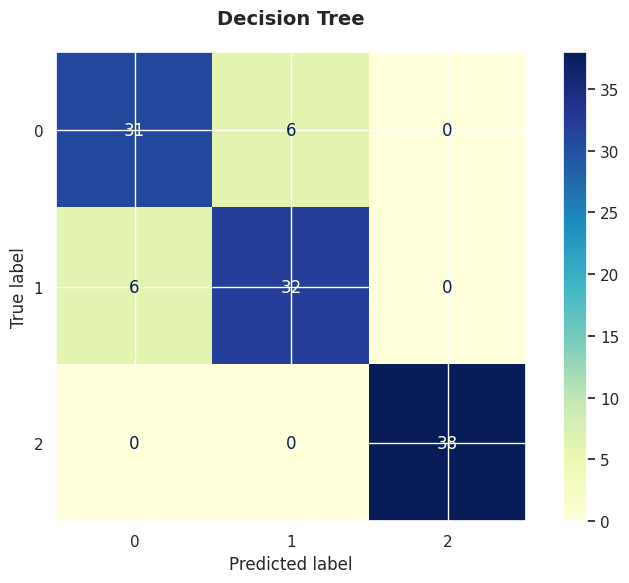

Running model: Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


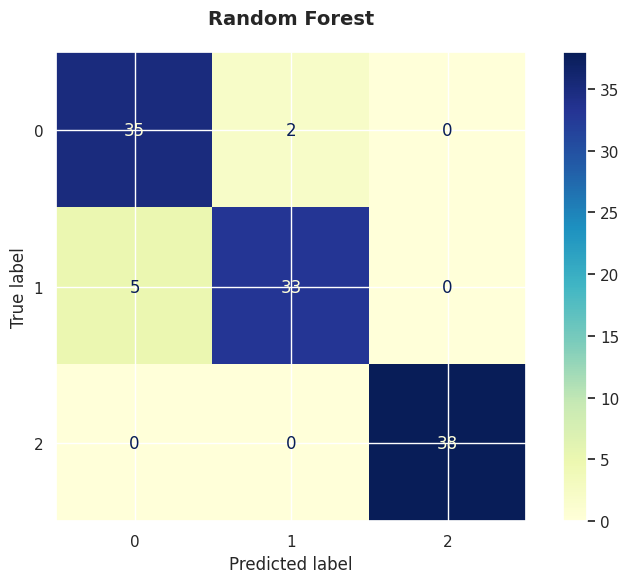

Running model: KNN


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


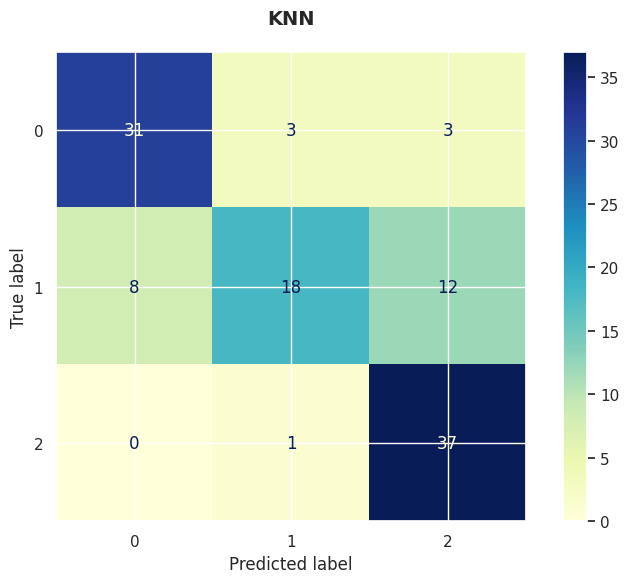

Running model: SVM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


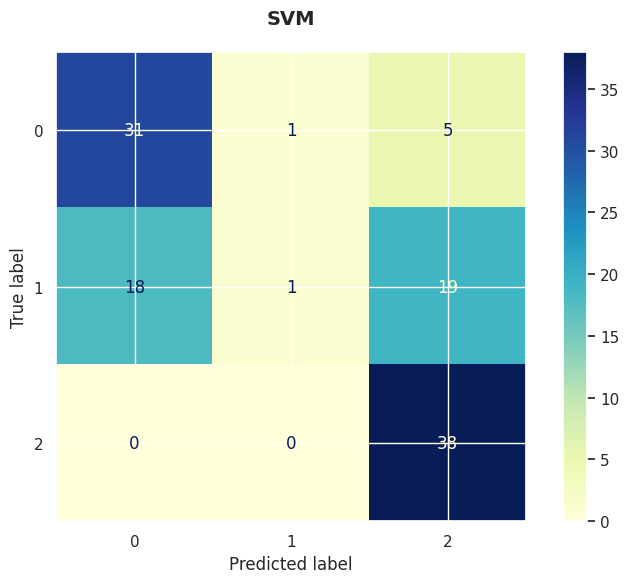

,model,accuracy,recall,precision,f1
0,Decision Tree,0.893805,0.893805,0.893805,0.893805
1,Random Forest,0.938053,0.938053,0.939855,0.937987
2,KNN,0.761062,0.761062,0.774687,0.745386
3,SVM,0.619469,0.619469,0.581403,0.508446


In [170]:
results = []

for model_name, model in models.items():
    res = {}
    print(f'Running model: {model_name}')

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    res['model'] = model_name
    res['accuracy'] = accuracy_score(y_valid, y_pred)
    res['recall'] = recall_score(y_valid, y_pred, average='weighted')
    res['precision'] = precision_score(y_valid, y_pred, average='weighted')
    res['f1'] = f1_score(y_valid, y_pred, average='weighted')

    results.append(res)
    conf_matrix = confusion_matrix(y_valid, y_pred)
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    display.plot(ax=ax, cmap='YlGnBu')

    ax.set_title(
        f"{res['model']}",
        fontsize=14,
        pad=20,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

results = pd.DataFrame(results)
results

Если обучить и проверить на данных без балансировки с помощью SMOTE, то наихудший результат у алгоритма SVM (F1=0.67), а наилучший у Random Forest (F1=0.85). При этом ни одна модель не определила верно миноритарный класс.

Если же обучить и проверить на данных, полученных после балансировки, то наилучший результат так же будет у Random Forest, но уже выше (F1=0.93). Попробуем улучшить эту метрику подбором гиперпараметров. По дефолту значение n_extimators = 100, а max_depth=None.

### Подбор гиперпараметров

In [178]:
scores = []

estimators = [50, 100, 150, 200]

for n_estim in estimators:
        score = {}
        rf = RandomForestClassifier(n_estimators=n_estim)

        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_valid)

        score['n_estimators'] = n_estim
        score['f1'] = f1_score(y_valid, y_pred, average='weighted')
        scores.append(score)

# вывод всех вариантов и их метрик
scores = pd.DataFrame(scores)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

,n_estimators,f1
0,50,0.911030
1,100,0.928824
2,150,0.928824
3,200,0.920070


In [180]:
scores = []

estimators = [50, 100, 150, 200]
depths = [5, 10, 15]
for n_estim in estimators:
    for depth in depths:
        score = {}
        rf = RandomForestClassifier(n_estimators=n_estim, max_depth=depth, random_state=42)

        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_valid)

        score['n_estimators'] = n_estim
        score['max_depth'] = depth
        score['f1'] = f1_score(y_valid, y_pred, average='weighted')
        scores.append(score)

# вывод всех вариантов и их метрик
scores = pd.DataFrame(scores)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

,n_estimators,max_depth,f1
0,50,5,0.919996
1,50,10,0.920070
2,50,15,0.920070
3,100,5,0.919898
4,100,10,0.929052
5,100,15,0.929052
6,150,5,0.910840
7,150,10,0.928824
8,150,15,0.928824
9,200,5,0.910840


In [181]:
scores[scores['f1'] == scores['f1'].max()]

,n_estimators,max_depth,f1
10,200,10,0.937832
11,200,15,0.937832


### Выбор лучшей модели и объяснение выбора

Заметим, что метрика не меняется при увеличении максмальной глубины деревьев, поэтому выберем модель с max_depth=10. Помним, что если деревья неограниченно растут, то они могут переобучиться.

In [182]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

# обучаем
rf.fit(X_train, y_train)

# предсказываем значения
y_pred = rf.predict(X_valid)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


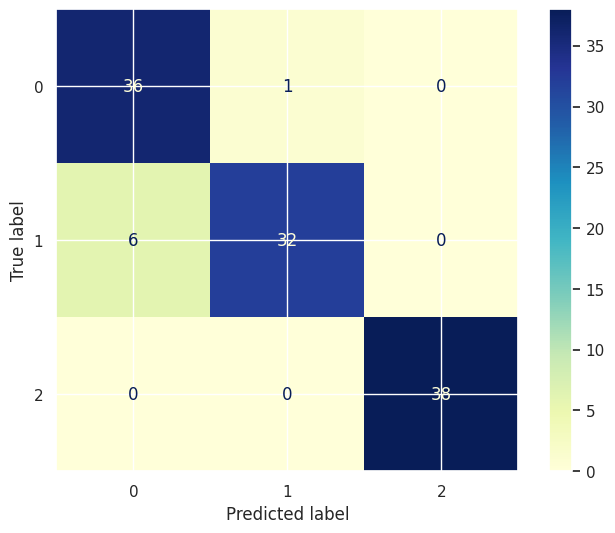

In [183]:
conf_matrix = confusion_matrix(y_valid, y_pred)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)

display = ConfusionMatrixDisplay(conf_matrix, display_labels=rf.classes_)

display.plot(ax=ax, cmap='YlGnBu')

Интерпретируем результаты:
- Первая строка (OFFSHORE - 0): 36 объектов предсказаны верно, 1 ошибочно классифицирован как ONSHORE.
- Втоаря строка (ONSHORE - 1): 32 объекта предсказаны верно, 6 ошибочно классифицированы как OFFSHORE.
- Третья строка (ONSHORE-OFFSHORE - 2): все объекты (38) предсказаны верно.

In [184]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91        37
           1       0.97      0.84      0.90        38
           2       1.00      1.00      1.00        38

    accuracy                           0.94       113
   macro avg       0.94      0.94      0.94       113
weighted avg       0.94      0.94      0.94       113



### Предсказание на тестовых данных

In [211]:
y_test_pred = rf.predict(X_test)
ans_df = pd.DataFrame(y_test_pred, columns=['Onshore/Offshore'])

ans_df.reset_index(inplace=True)
ans_df.to_csv('submition.csv', index=False)

скриншот с лидерборда Kaggle

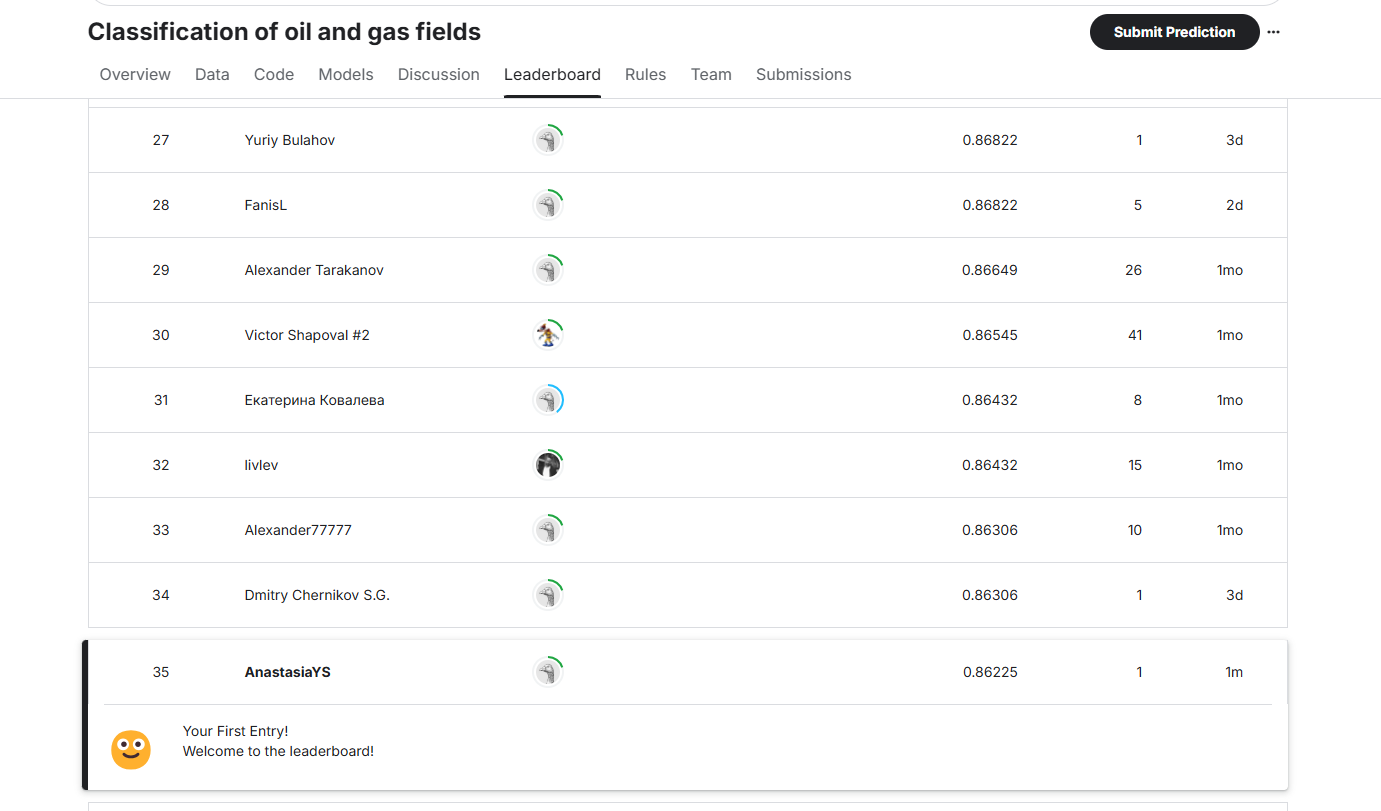